<a href="https://colab.research.google.com/github/Motaz-Saidani/Credit-Default-Risk-Prediction/blob/main/Credit_Default_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# <center> Credit Default Risk Prediction


Using a small unbalanced dataset, I will try to make the most of it by preprocessing, cleaning, extracting features, & applying advanced statistical techniques to yield robust results & maximize the performance of classification models in predicting credit default. The models will be compared by different accuracy evaluation methods to see which one fits the best this specific dataset. Algorithms will be used are:

*   KNN,
*   Decision Tree,
*   Support Vector Machine, and 
*   Logistic Regression.



In [1]:
import itertools
import numpy as np
import pandas as pd
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. It includes details of 346 customers whose loans are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### Importing Data


In [2]:
!gdown --id 11cYuOVK6vTsoql2yqtZAsNY62sDbeUvT

Downloading...
From: https://drive.google.com/uc?id=11cYuOVK6vTsoql2yqtZAsNY62sDbeUvT
To: /content/loan_data.csv
100% 23.7k/23.7k [00:00<00:00, 45.7MB/s]


In [3]:
df = pd.read_csv('loan_data.csv')
df[:3]

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female


# Data visualization and pre-processing


In [4]:
df.describe()

,Principal,terms,age
count,400.00000,400.000000,400.000000
mean,939.75000,22.550000,31.060000
std,120.33761,8.100094,6.033441
min,300.00000,7.000000,18.000000
25%,800.00000,15.000000,27.000000
50%,1000.00000,30.000000,30.000000
75%,1000.00000,30.000000,35.000000
max,1000.00000,30.000000,51.000000


###Checking for missing values

In [5]:
df.isna().sum()

loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

###Types of data 

In [6]:
df.dtypes

loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Converting to date time object


In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female


### Exploring Data

In [8]:
df['loan_status'].value_counts()

PAIDOFF       300
COLLECTION    100
Name: loan_status, dtype: int64

300 people have paid off the loan on time while 100 have gone into collection


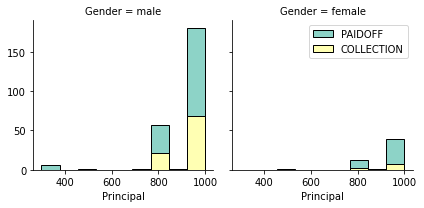

In [9]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

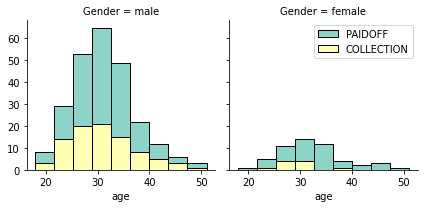

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Feature selection/extraction


### Day of the week people get the loan


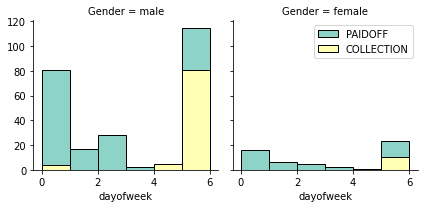

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 7)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


people who get the loan at the end of the week don't pay it off, so I will use Feature binarization to set a threshold value less than day 4


In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(3)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0


In [13]:
df.groupby(['weekend'])['loan_status'].value_counts(normalize=True)

weekend  loan_status
0        PAIDOFF        0.975155
         COLLECTION     0.024845
1        PAIDOFF        0.598326
         COLLECTION     0.401674
Name: loan_status, dtype: float64

2 % of people who get there loan during working don't days pay theme off.

40 % of people who get theirs during weekend don't pay them off.


### Duration between effective date & due date


In [14]:
# duration in seconds
duration = (df.due_date - df.effective_date).dt.total_seconds()
# duration in day
df['duration_days'] = (duration/(60*60*24)).astype(int)

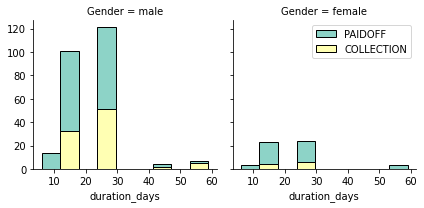

In [15]:
bins = np.linspace(df.duration_days.min(), df.duration_days.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'duration_days', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

## Converting Categorical features to numerical values


In [16]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.841270
        COLLECTION     0.158730
male    PAIDOFF        0.732938
        COLLECTION     0.267062
Name: loan_status, dtype: float64

84 % of female pay there loans while only 73 % of males pay theirs


converting male to 0 and female to 1:


In [17]:
df.Gender = df.Gender.map(dict(female=1, male=0))
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,duration_days
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,29
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0,29
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,29
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,14
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,29


## One Hot Encoding


In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=False)

education             loan_status
Bechalor              PAIDOFF         41
                      COLLECTION      11
High School or Below  PAIDOFF        123
                      COLLECTION      49
Master or Above       PAIDOFF          3
                      COLLECTION       1
college               PAIDOFF        133
                      COLLECTION      39
Name: loan_status, dtype: int64

#### Features before One Hot Encoding


In [19]:
df[['Principal','age','Gender','weekend','education']].head()

,Principal,age,Gender,weekend,education
0,1000,45,0,0,High School or Below
1,1000,50,1,0,Bechalor
2,1000,33,1,0,Bechalor
3,1000,27,0,0,college
4,1000,28,1,1,college


#### Features after One Hot Encoding


In [20]:
feature = df[['Principal','age','duration_days','Gender','weekend']]
feature = pd.concat([feature,pd.get_dummies(df['education'])], axis=1)
feature.drop(['Master or Above'], axis = 1,inplace=True)
feature.head()

,Principal,age,duration_days,Gender,weekend,Bechalor,High School or Below,college
0,1000,45,29,0,0,0,1,0
1,1000,50,29,1,0,1,0,0
2,1000,33,29,1,0,1,0,0
3,1000,27,14,0,0,0,0,1
4,1000,28,29,1,1,0,0,1


### Feature Selection


In [21]:
X = feature

In [22]:
y = df['loan_status'].values
np.unique(y, return_counts=True)

(array(['COLLECTION', 'PAIDOFF'], dtype=object), array([100, 300]))

As we can see, the target variable is imbalanced (COLLECTION=100, PAIDOFF=300). Thus, we will use SMOTE-NC to over-sample the minority class. The oversampling must be done after splitting data into training & testing sets

## Splitting Data


In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=100)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (300, 8) (300,)
Test set: (100, 8) (100,)


In [24]:
np.unique(y_train, return_counts=True)

(array(['COLLECTION', 'PAIDOFF'], dtype=object), array([ 78, 222]))

In our training set, the minority class is COLLECTION with 78 occurences. The Majority class is PAIDOFF with 222 occurences.

We will balance the target classes using the SMOTE-NC technique.

## Minority Oversampling 

In [25]:
from imblearn.over_sampling import SMOTENC

In [26]:
X_train.head(3)

,Principal,age,duration_days,Gender,weekend,Bechalor,High School or Below,college
163,1000,27,14,1,0,0,0,1
229,800,26,14,0,0,0,0,1
213,1000,27,29,0,0,0,1,0


In [27]:
# For SMOTE-NC we need to pinpoint the column position of the categorical features
smote_nc = SMOTENC(categorical_features= [3,4,5,6,7], sampling_strategy='minority', random_state=100)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

In [28]:
np.unique(y_train_smote, return_counts=True)

(array(['COLLECTION', 'PAIDOFF'], dtype=object), array([222, 222]))

The target variable is now balanced

## Normalizing Data
(technically should be done after splitting data)

In [29]:
X_train_smote = preprocessing.StandardScaler().fit(X_train_smote).transform(X_train_smote)
X_train_smote.shape

(444, 8)

# Training Classification Models

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

We further split the training sets into train and validation sets.

In [31]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=100)
print ('Train Set:', X_train1.shape,  y_train1.shape)
print ('Validation Set:', X_val.shape,  y_val.shape)

Train Set: (355, 8) (355,)
Validation Set: (89, 8) (89,)


## K Nearest Neighbor(KNN)

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
# Finding the best K
params = {'n_neighbors':[*range(2, 31, 1)],}

model_trial = KNeighborsClassifier()
grid_search = GridSearchCV(model_trial, params, scoring='accuracy', cv=10)
grid_search.fit(X_train_smote, y_train_smote)
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [34]:
# Fitting Model
k=7

knn_model = KNeighborsClassifier(n_neighbors = k)
knn_model.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=7)

## Decision Tree


Model

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import pydotplus
from IPython.display import Image, HTML

In [36]:
# Finding the best hyperparams
params = {'max_depth': [*range(1, 11, 1)],
          'max_leaf_nodes': [*range(2, 11, 1)]}          

model_trial = DecisionTreeClassifier()
grid_search = GridSearchCV(model_trial, params, scoring='accuracy', cv=10)
grid_search.fit(X_train_smote, y_train_smote)
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4)

In [37]:
# Fitting the model
max_depth = 3
max_leaf = 4

tree_model = DecisionTreeClassifier(max_depth=max_depth, 
                                    max_leaf_nodes=max_leaf)
tree_model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4)

In [38]:
def tree_graph(tree_model):
  #Creating Dot Data
  dot_data = tree.export_graphviz(tree_model, 
                                 out_file=None, 
                                 feature_names=list(X.columns.values), 
                                 class_names=tree_model.classes_, 
                                 rounded=True, 
                                 filled=True) 

  #Creating Graph from DOT data
  graph = pydotplus.graph_from_dot_data(dot_data)

  # Show graph
  display(Image(graph.create_png()))

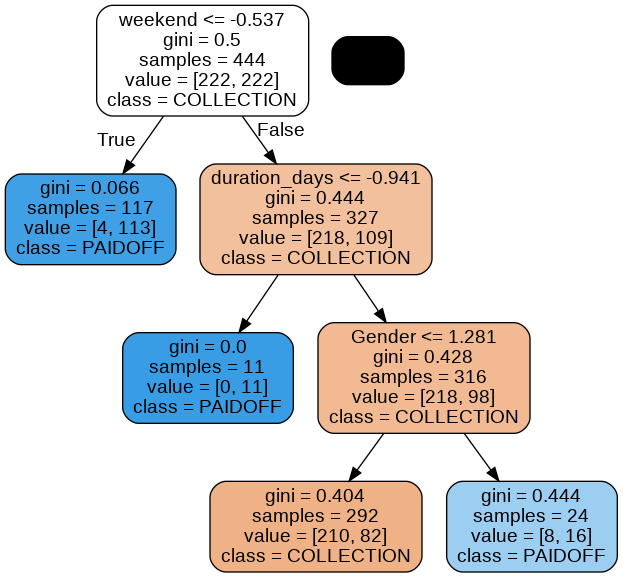

In [39]:
tree_graph(tree_model)

## Support Vector Machine


In [40]:
from sklearn import svm

In [41]:
# Finding the best hyperparams
params = {'C': [10, 1],
          'degree': [*range(1, 10, 1)],
          'probability': [True, False]}

model_trial = svm.SVC()
grid_search = GridSearchCV(model_trial, params, scoring='accuracy', cv=10)
grid_search.fit(X_train_smote, y_train_smote)
grid_search.best_estimator_

SVC(C=1, degree=1, probability=True)

In [42]:
# Fitting the model
C = 1
degree = 1
probability = True

svm_model = svm.SVC(C=C, 
                    degree=degree,
                    probability=probability)

svm_model.fit(X_train_smote, y_train_smote) 

SVC(C=1, degree=1, probability=True)

## Logistic Regression


In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
# Finding the best hyperparams
params = {
    'C': [10, 1],
    'max_iter': [1000, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
          }

model_trial = LogisticRegression()
grid_search = GridSearchCV(model_trial, params, scoring='accuracy', cv=10)
grid_search.fit(X_train_smote, y_train_smote)
grid_search.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=1, max_iter=1000, solver='newton-cg')

In [45]:
# Fitting the model
C = 1
max_iter = 1000 
solver = 'newton-cg'

logistic_model = LogisticRegression(C=C, 
                                    max_iter=max_iter, 
                                    solver=solver)

logistic_model.fit(X_train_smote, y_train_smote)

LogisticRegression(C=1, max_iter=1000, solver='newton-cg')

<w>

# Model Evaluation using Test set


Libraries

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score

Confusion matrix

In [47]:
def confusion_matrix_plot(model, y, yhat):
  cm = confusion_matrix(y, yhat)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
  cm_display.plot(cmap='Blues')
  plt.show()


Evaluation metrics

In [48]:
def model_evaluation(algorithm_name, yhat_test):
  
  balanced_accuracy_test = balanced_accuracy_score(y_test, yhat_test)
  accuracy_test = accuracy_score(y_test, yhat_test)
  precision = precision_score(y_test, yhat_test, pos_label='PAIDOFF')
  recall = recall_score(y_test, yhat_test, pos_label='PAIDOFF')
  jaccard = jaccard_score(y_test, yhat_test, pos_label='PAIDOFF')
  f1score = f1_score(y_test, yhat_test, average='weighted')

  evaluation_table = pd.DataFrame({'Test Accuracy': accuracy_test,
                                   'Balanced Accuracy': balanced_accuracy_test, 
                                   'Precision': precision, 
                                   'Recall': recall,
                                   'Jaccard-Score': jaccard, 
                                   'F1-Score': f1score},
                                    index=[algorithm_name])
  
  return evaluation_table

Standardizing the test set


In [49]:
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test.shape

(100, 8)

## KNN Evaluation

In [50]:
yhat_knn_test = knn_model.predict(X_test)
yhat_prob_knn_test = (knn_model.predict_proba(X_test))[:,1]

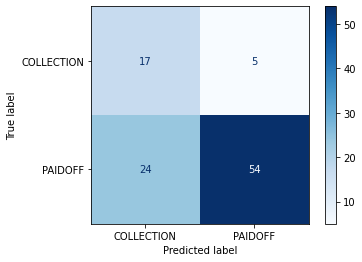

In [51]:
confusion_matrix_plot(knn_model, y_test, yhat_knn_test)

In [52]:
knn_eval = model_evaluation('KNN', yhat_knn_test)
knn_eval

,Test Accuracy,Balanced Accuracy,Precision,Recall,Jaccard-Score,F1-Score
KNN,0.71,0.732517,0.915254,0.692308,0.650602,0.733621


<w>

## Decision Tree Evaluation

In [53]:
yhat_tree_test = tree_model.predict(X_test)
yhat_prob_tree_test = (tree_model.predict_proba(X_test))[:,1]

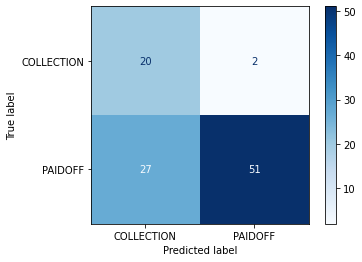

In [54]:
confusion_matrix_plot(tree_model, y_test, yhat_tree_test)

In [55]:
tree_eval = model_evaluation('Decision Tree',  yhat_tree_test)
tree_eval

,Test Accuracy,Balanced Accuracy,Precision,Recall,Jaccard-Score,F1-Score
Decision Tree,0.71,0.781469,0.962264,0.653846,0.6375,0.734864


<w>

## SVM Evaluation

In [56]:
yhat_svm_test = svm_model.predict(X_test)
yhat_prob_svm_test = (svm_model.predict_proba(X_test))[:,1]

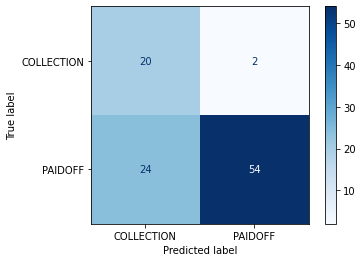

In [57]:
confusion_matrix_plot(svm_model, y_test, yhat_svm_test)

In [58]:
svm_eval = model_evaluation('SVM', yhat_svm_test)
svm_eval

,Test Accuracy,Balanced Accuracy,Precision,Recall,Jaccard-Score,F1-Score
SVM,0.74,0.800699,0.964286,0.692308,0.675,0.76199


<w>

## Logistic Reg. Evaluation

In [59]:
yhat_logistic_test = logistic_model.predict(X_test)
yhat_prob_logistic_test = (logistic_model.predict_proba(X_test))[:,1]

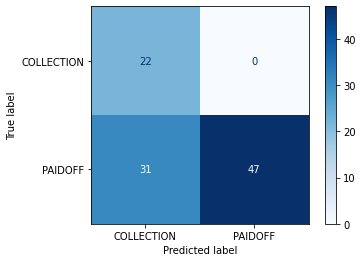

In [60]:
confusion_matrix_plot(logistic_model, y_test, yhat_logistic_test)

In [61]:
logistic_eval = model_evaluation('Logistic Reg.', yhat_logistic_test)
logistic_eval

,Test Accuracy,Balanced Accuracy,Precision,Recall,Jaccard-Score,F1-Score
Logistic Reg.,0.69,0.801282,1.0,0.602564,0.602564,0.715627


## Evaluation table & ROC-AUC


In [62]:
from pandas.io.formats.style import Styler
from sklearn.metrics import roc_curve, auc

Evaluation Table

In [63]:
# Concatenating models evaluations
evaluation_table = pd.concat([knn_eval, tree_eval, svm_eval, logistic_eval])
# Rounding values
evaluation_table = evaluation_table.style.format('{:.2%}')
# Highliting mins and maxs
evaluation_table = evaluation_table.highlight_max(color='lightcyan').highlight_min(color='mistyrose')
# Adding title
evaluation_table = evaluation_table.set_caption('Evaluation Table of Classification Algorithms')
evaluation_table = evaluation_table.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'),('font-size', '30px')]}])

ROC Curves

In [64]:
knn_fpr, knn_tpr, threshold = roc_curve(y_test, yhat_prob_knn_test, pos_label='PAIDOFF')
auc_knn = auc(knn_fpr, knn_tpr)

tree_fpr, tree_tpr, threshold = roc_curve(y_test, yhat_prob_tree_test, pos_label='PAIDOFF')
auc_tree = auc(tree_fpr, tree_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(y_test, yhat_prob_svm_test, pos_label='PAIDOFF')
auc_svm = auc(svm_fpr, svm_tpr)

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, yhat_prob_logistic_test, pos_label='PAIDOFF')
auc_logistic = auc(logistic_fpr, logistic_tpr)

Report

In [65]:
def report():
  display(evaluation_table)
  print('\n\n')

  plt.figure(figsize=(5, 5), dpi=100)
  plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (auc = %0.3f)' % auc_knn)
  plt.plot(tree_fpr, tree_tpr, marker='.', label='Decision Tree (auc = %0.3f)' % auc_tree)
  plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM (auc = %0.3f)' % auc_svm)
  plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic Reg.(auc = %0.3f)' % auc_logistic)
  plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label='Random')

  plt.title('ROC-AUC')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

<w>

#REPORT

,Test Accuracy,Balanced Accuracy,Precision,Recall,Jaccard-Score,F1-Score
KNN,71.00%,73.25%,91.53%,69.23%,65.06%,73.36%
Decision Tree,71.00%,78.15%,96.23%,65.38%,63.75%,73.49%
SVM,74.00%,80.07%,96.43%,69.23%,67.50%,76.20%
Logistic Reg.,69.00%,80.13%,100.00%,60.26%,60.26%,71.56%


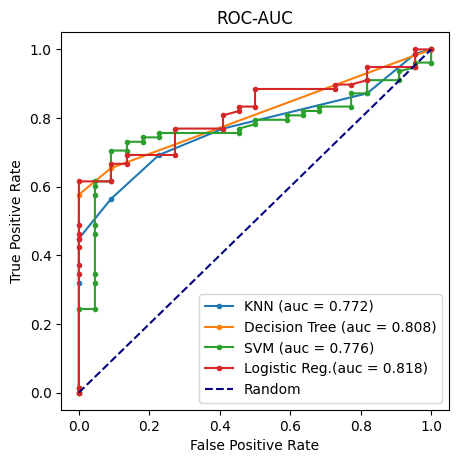

In [66]:
report()
